## Assess the impact of atmosphere on offset time-seris

Run the following `prep_*.ipynb` to generate the input time-series for this analysis:

1. prep_sar.ipynb
2. prep_era5.ipynb
3. prep_gim_tec.ipynb
4. prep_igs_tec.ipynb
5. prep_solid_earth_tide.ipynb

### Contents

0. Read data and initiate utils functions
1. SAR vs. GIM/IGS TEC
2. Residual (SAR - TEC) vs. ERA5
3. Residual (SAR - TEC - ERA5) vs. SET
4. Residual (SAR - TEC - ERA5 - SET) vs. Distance btw. SAR and TEC
5. Differential TS: Residual (SAR - TEC - ERA5) vs. SET

In [130]:
%matplotlib inline
import os
import pickle
import datetime as dt
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt, ticker, gridspec
from mintpy.utils import plot as pp
from offset import utils
plt.rcParams.update({'font.size': 12})
fig_size = [9, 4]

# config
n = 3                   # number of med abs dev
dt_s1ab = dt.datetime(2016, 10, 7)    # dateime separating S1A and S1B
tec_src = 'GIM'            # GIM / IGS
tec_type = 'subTEC'        # subTEC / TEC
save = True

# location of interest
#box = (85, 25, 145, 70);  box_suffix = 'boxCC'   # box to read for range offset in (x0, y0, x1, y1)
box = (10, 55, 20, 70);   box_suffix = 'boxCL'   # box in the center left with low  altitude
box = (200, 15, 215, 30); box_suffix = 'boxLR'   # box in the lower right with high altitude

# dir
proj_dir = os.path.expanduser('~/data/Tarapaca/SenAT149')
work_dir = os.path.join(proj_dir, 'offset_comp', box_suffix)
os.chdir(work_dir)
print('Go to directory', work_dir)

Go to directory /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR


### 0. Read all time-series

In [146]:
# utils function
def plot_dot_figure(ax, x, y, xname, yname, vlim, vstep=0.2, fbase='offset'):
    ax.plot(x, y, 'k.')
    ax.plot(vlim, vlim, 'k--')

    # axis format
    ax.xaxis.set_major_locator(ticker.MultipleLocator(vstep))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(vstep))
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_xlim(vlim)
    ax.set_ylim(vlim)
    ax.set_xlabel('${{{b}}}_{{{n}}}$ [m]'.format(b=fbase, n=xname), color='C0')
    ax.set_ylabel('${{{b}}}_{{{n}}}$ [m]'.format(b=fbase, n=yname), color='C1')
    ax.set_aspect('equal', 'box')

    # stats
    rmse = np.sqrt(np.sum((y - x)**2) / (x.size - 1))
    r2 = stats.linregress(y, x)[2]
    msg = r'$RMSE$ = {:.1f} cm'.format(rmse*100)
    msg += '\n'
    msg += r'$R^2$ = {:.2f}'.format(r2)
    ax2.annotate(msg, xy=(0.07, 0.65), xycoords='axes fraction', color='k')

    return

# read files into dict
dDict, flag = utils.read_offset_files(work_dir)

read SAR data from pickle file: /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/sar.pickle
read GIM data from pickle file: /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/TECgim_median.pickle
read IGS data from pickle file: /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/TECigs.pickle
read ERA data from pickle file: /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/era5.pickle
read SET data from pickle file: /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/set.pickle


### 1. SAR vs. (sub)TEC (IGS / GIM)

save figure to file /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/TS_SAR_vs_TEC.png


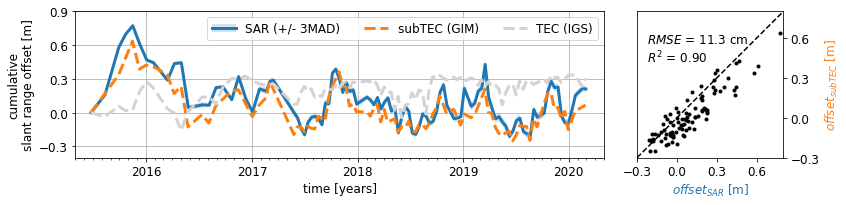

In [147]:
fig = plt.figure(figsize=(12, 3))
gs  = gridspec.GridSpec(3, 12, figure=fig)
ax  = fig.add_subplot(gs[:, 0:-3])
ax2 = fig.add_subplot(gs[:, -3:])

# dset 1: SAR
x1  = dDict['SAR']['time']
y1  = dDict['SAR']['range_offset_med']
y1e = dDict['SAR']['range_offset_mad'] * n

# dset 2: GIM TEC
x2 = dDict['GIM']['time']
y2 = dDict['GIM']['range_delay4Cband_subTEC']

# dset 3: IGS TEC
# something is strange on the sign of IGS TEC, need to check more carefully.
x3 = dDict['IGS']['time']
y3 = dDict['IGS']['range_delay4Cband_TEC'] * -1

# align other data to SAR with a constant
# Notes at 2020-08-25 by ZY: tried use the median difference as yoff, not noticeable difference, thus use the 1st for simplicity
y1 -= y1[0]
y2 -= y2[0]
y3 -= y3[0]

p10  = ax.fill_between(x1, y1 - y1e, y1 + y1e, fc='C0', ec='none', alpha=0.2)
p11, = ax.plot(x1, y1,  '-', color='C0',        ms=6, lw=3)
p2,  = ax.plot(x2, y2, '--', color='C1',        ms=6, lw=3)
p3,  = ax.plot(x3, y3, '--', color='lightgray', ms=6, lw=3)

# axis format
vstep = 0.3
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.4, 0.9)
ax.yaxis.set_major_locator(ticker.MultipleLocator(vstep))
ax.set_xlabel('time [years]')
ax.set_ylabel('cumulative\nslant range offset [m]')
pp.auto_adjust_xaxis_date(ax, x1, every_year=1, buffer_year=None)
ax.legend(handles=[(p10, p11), p2, p3],
          labels=['SAR (+/- 3MAD)', 'subTEC (GIM)', 'TEC (IGS)'],
          loc='upper right', ncol=3)
ax.grid('on')

## dot figure
plot_dot_figure(ax2, x=y1[flag], y=y2, xname='SAR', yname='subTEC', vlim=(-0.3, 0.8), vstep=vstep)
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'TS_SAR_vs_TEC.png')
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 2. SAR - subTEC vs. ERA5

save figure to file /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/TS_SAR_TEC_vs_ERA5.png


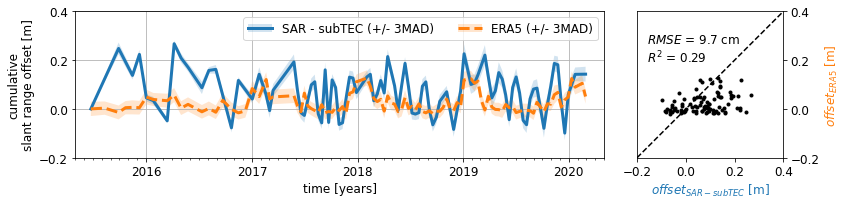

In [148]:
fig = plt.figure(figsize=(12, 3))
gs  = gridspec.GridSpec(3, 12, figure=fig)
ax  = fig.add_subplot(gs[:, 0:-3])
ax2 = fig.add_subplot(gs[:, -3:])

# dset 1: SAR - subTEC
x1  = dDict['GIM']['time']
y1  = dDict['SAR']['range_offset_med'][flag]
y1 -= dDict['GIM']['range_delay4Cband_subTEC']
y1e = dDict['SAR']['range_offset_mad'][flag] * n

# dset 2: ERA5
x2  = dDict['ERA']['time']
y2  = dDict['ERA']['range_delay_tropo_med']
y2e = dDict['ERA']['range_delay_tropo_mad'] * n

y1 -= y1[0]
y2 -= y2[0]

p10  = ax.fill_between(x1, y1 - y1e, y1 + y1e, fc='C0', ec='none', alpha=0.2)
p20  = ax.fill_between(x2, y2 - y2e, y2 + y2e, fc='C1', ec='none', alpha=0.2)
p11, = ax.plot(x1, y1,  '-', color='C0', ms=6, lw=3)
p21, = ax.plot(x2, y2, '--', color='C1', ms=6, lw=3)

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.2, 0.4)
ax.set_xlabel('time [years]')
ax.set_ylabel('cumulative\nslant range offset [m]')
pp.auto_adjust_xaxis_date(ax, x1, every_year=1, buffer_year=None)
ax.legend(handles=[(p10, p11), (p20, p21)],
          labels=['SAR - subTEC (+/- 3MAD)', 'ERA5 (+/- 3MAD)'],
          loc='best', ncol=2)
ax.grid('on')

## dot figure
plot_dot_figure(ax2, x=y1, y=y2[flag], xname='SAR - subTEC', yname='ERA5', vlim=(-0.2, 0.4), vstep=0.2)
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'TS_SAR_TEC_vs_ERA5.png')
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 3. SAR - subTEC - ERA5 vs. SET

save figure to file /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/TS_SAR_TEC_ERA5_vs_SET.png


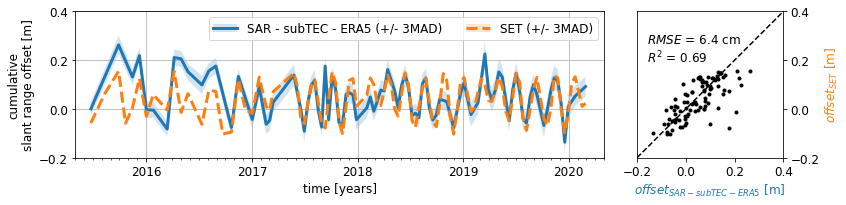

In [149]:
fig = plt.figure(figsize=(12, 3))
gs  = gridspec.GridSpec(3, 12, figure=fig)
ax  = fig.add_subplot(gs[:, 0:-3])
ax2 = fig.add_subplot(gs[:, -3:])

# dset 1: SAR - subTEC - ERA5
x1  = dDict['GIM']['time']
y1  = dDict['SAR']['range_offset_med'][flag]
y1 -= dDict['GIM']['range_delay4Cband_subTEC']
y1 -= dDict['ERA']['range_delay_tropo_med'][flag]
y1e = (dDict['SAR']['range_offset_mad'][flag] ** 2 
       + dDict['ERA']['range_delay_tropo_mad'][flag] ** 2) ** 0.5 * n

# dset 2: SET
x2  = dDict['SET']['time']
y2  = dDict['SET']['range_delay_SET_med'] * -1
y2e = dDict['SET']['range_delay_SET_mad'] * n

y1 -= y1[0]
y2 -= np.median((y2[flag] - y1)[x2[flag] > dt_s1ab])

p10  = ax.fill_between(x1, y1 - y1e, y1 + y1e, fc='C0', ec='none', alpha=0.2)
p20  = ax.fill_between(x2, y2 - y2e, y2 + y2e, fc='C1', ec='none', alpha=0.2)
p11, = ax.plot(x1, y1,  '-', color='C0', ms=6, lw=3)
p21, = ax.plot(x2, y2, '--', color='C1', ms=6, lw=3)

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.2, 0.4)
ax.set_xlabel('time [years]')
ax.set_ylabel('cumulative\nslant range offset [m]')
pp.auto_adjust_xaxis_date(ax, x1, every_year=1, buffer_year=None)
ax.legend(handles=[(p10, p11), (p20, p21)],
          labels=['SAR - subTEC - ERA5 (+/- 3MAD)', 'SET (+/- 3MAD)'],
          loc='upper right', ncol=2)
ax.grid('on')

## dot figure
plot_dot_figure(ax2, x=y1, y=y2[flag], xname='SAR - subTEC - ERA5', yname='SET', vlim=(-0.2, 0.4), vstep=0.2)
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'TS_SAR_TEC_ERA5_vs_SET.png')
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 4. SAR - subTEC - ERA5 - SET

save figure to file /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/TS_SAR_TEC_ERA5_SET.png


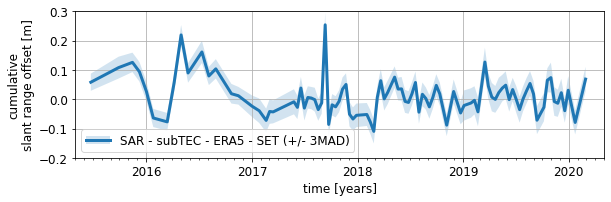

In [150]:
fig = plt.figure(figsize=(12, 3))
gs  = gridspec.GridSpec(3, 12, figure=fig)
ax  = fig.add_subplot(gs[:, 0:-3])
ax2 = fig.add_subplot(gs[:, -3:])

# dset 1: SAR - subTEC - ERA5
x1  = dDict['GIM']['time']
y1  = dDict['SAR']['range_offset_med'][flag]
y1 -= dDict['GIM']['range_delay4Cband_subTEC']
y1 -= dDict['ERA']['range_delay_tropo_med'][flag]
y1 -= dDict['SET']['range_delay_SET_med'][flag] * -1
y1e = (dDict['SAR']['range_offset_mad'][flag] ** 2 
       + dDict['ERA']['range_delay_tropo_mad'][flag] ** 2 
       + dDict['SET']['range_delay_SET_mad'][flag] ** 2) ** 0.5 * n

y1 -= np.median(y1[x1 > dt_s1ab])

p10  = ax.fill_between(x1, y1 - y1e, y1 + y1e, fc='C0', ec='none', alpha=0.2)
p11, = ax.plot(x1, y1,  '-', color='C0', ms=6, lw=3)

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.2, 0.3)
ax.set_xlabel('time [years]')
ax.set_ylabel('cumulative\nslant range offset [m]')
pp.auto_adjust_xaxis_date(ax, x1, every_year=1, buffer_year=None)
ax.legend(handles=[(p10, p11)],
          labels=['SAR - subTEC - ERA5 - SET (+/- 3MAD)'],
          loc='best', ncol=1)
ax.grid('on')

## dot figure
plot_dot_figure(ax2, x=y1, y=y1, xname='SAR - subTEC - ERA5', yname='SET', vlim=(-0.2, 0.3), vstep=0.2)
fig.tight_layout()
ax2.set_visible(False)

# output
out_fig = os.path.join(work_dir, 'TS_SAR_TEC_ERA5_SET.png')
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 4.2 Residual (SAR - TEC - ERA5 - SET) vs. TEC-SAR distance

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_res_Sen_subTEC_ERA5_SET_vs_dist.png


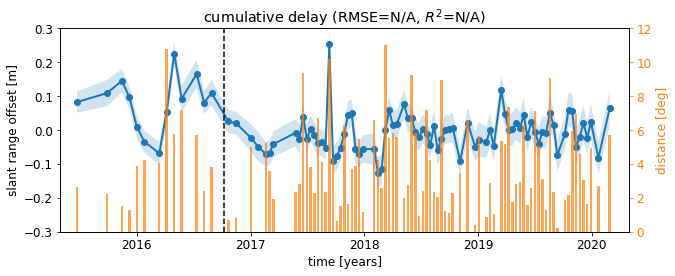

In [18]:
out_fig_suffix = 'res_Sen_{}_ERA5_SET_vs_dist'.format(tec_type)

## data
key = tec_type + tec_src.lower()
res = sar[flag] - tec[key]['delay'] - era[flag] - sld[flag]
res_err = (sar_err[flag]**2 + era_err[flag]**2 + sld_err[flag]**2) ** 0.5
dist = np.array(dDict['GIM']['dist_deg'])

## plot
fig, ax = plt.subplots(figsize=[9, 4])

p0, = ax.plot(x2, res,  '-o', color='C0', ms=6, lw=2)
p1  = ax.fill_between(x2, res - res_err, res + res_err, fc='C0', ec='none', alpha=0.2)
# axis format
ax.axvline(x=dt_s1ab, linestyle='--', color='k')   # S1A / S1B
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('cumulative delay (RMSE=N/A, $R^2$=N/A)')
#ax.legend([(p0, p1)], ['resid (SAR - {} - ERA5 - SET) +/- {} MAD'.format(tec_type, n)], loc='upper right')
fig.tight_layout()

ax2 = ax.twinx()
ax2.bar(x2, dist, width=8, color='C1', label='dist', alpha=0.7)
# axis format
ax2.tick_params(which='both', axis='y', colors='C1')
ax2.set_ylim(0, 12)
ax2.set_ylabel('distance [deg]', color='C1')

# output
out_fig = os.path.join(work_dir, 'TS_{}.png'.format(out_fig_suffix))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 5. Differential TS: residual (SAR - TEC - ERA5) v.s. SET

save figure to file /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/DIFF_SAR_TEC_ERA5_vs_SET.png


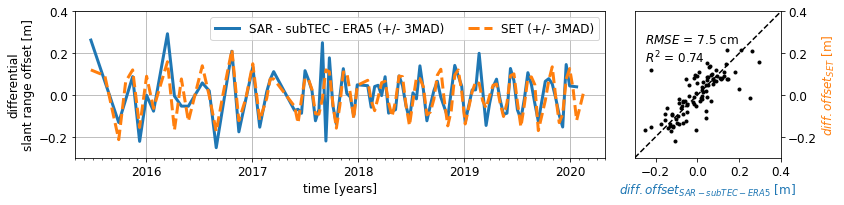

In [145]:
fig = plt.figure(figsize=(12, 3))
gs  = gridspec.GridSpec(3, 12, figure=fig)
ax  = fig.add_subplot(gs[:, 0:-3])
ax2 = fig.add_subplot(gs[:, -3:])

# dset 1: SAR - subTEC - ERA5
x1  = dDict['GIM']['time']
y1  = dDict['SAR']['range_offset_med'][flag]
y1 -= dDict['GIM']['range_delay4Cband_subTEC']
y1 -= dDict['ERA']['range_delay_tropo_med'][flag]
y1e = (dDict['SAR']['range_offset_mad'][flag] ** 2 
       + dDict['ERA']['range_delay_tropo_mad'][flag] ** 2) ** 0.5 * n

# dset 2: SET
x2  = dDict['SET']['time']
y2  = dDict['SET']['range_delay_SET_med'] * -1
y2e = dDict['SET']['range_delay_SET_mad'] * n

y1 -= y1[0]
y2 -= np.median((y2[flag] - y1)[x2[flag] > dt_s1ab])

p11, = ax.plot(x1[:-1], np.diff(y1),  '-', color='C0', ms=6, lw=3)
p21, = ax.plot(x2[:-1], np.diff(y2), '--', color='C1', ms=6, lw=3)

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.3, 0.4)
ax.set_xlabel('time [years]')
ax.set_ylabel('differential\nslant range offset [m]')
pp.auto_adjust_xaxis_date(ax, x1, every_year=1, buffer_year=None)
ax.legend(handles=[p11, p21],
          labels=['SAR - subTEC - ERA5 (+/- 3MAD)', 'SET (+/- 3MAD)'],
          loc='upper right', ncol=2)
ax.grid('on')

## dot figure
plot_dot_figure(ax2, x=np.diff(y1), y=np.diff(y2[flag]),
                xname='SAR - subTEC - ERA5', 
                yname='SET',
                vlim=(-0.3, 0.4), vstep=0.2, fbase='diff. offset')
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'DIFF_SAR_TEC_ERA5_vs_SET.png')
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

res min/max: -0.3/0.3 cm
sld min/max: -0.2/0.2 cm
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_diff_res_Sen_subTEC_ERA5_vs_SET.png
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/DOT_diff_res_Sen_subTEC_ERA5_vs_SET.png


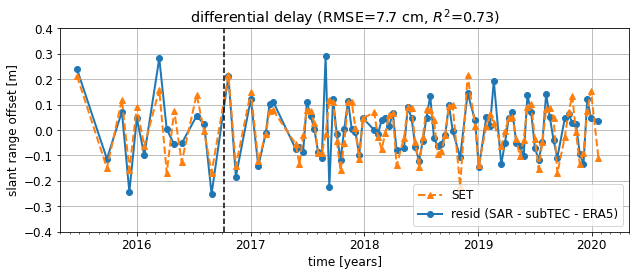

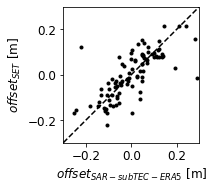

In [10]:
out_fig_suffix = 'diff_res_Sen_{}_ERA5_vs_SET'.format(tec_type)

## data
key = tec_type + tec_src.lower()
res_diff = sar[flag] - tec[key]['delay'] - era[flag]
sld_diff = np.array(dDict['SET']['range_delay_SET_med'])[flag] * -1    # predicted offset from SET
sld_diff -= np.median(sld_diff - res_diff)

ref_diff = np.diff(res_diff)
sld_diff = np.diff(sld_diff)

# stats
rmse = np.sqrt(np.sum((ref_diff - sld_diff)**2) / (np.sum(flag) - 2))
r2   = stats.linregress(ref_diff, sld_diff)[2]
stats_msg = 'RMSE={:.1f} cm, $R^2$={:.2f}'.format(rmse*100, r2)
print('res min/max: {:.1f}/{:.1f} cm'.format(np.min(ref_diff), np.max(ref_diff)))
print('sld min/max: {:.1f}/{:.1f} cm'.format(np.min(sld_diff), np.max(sld_diff)))

## plot
fig, ax = plt.subplots(figsize=fig_size)
p0, = ax.plot(x2[:-1], ref_diff,  '-o', color='C0', ms=6, lw=2)
p2, = ax.plot(x2[:-1], sld_diff, '--^', color='C1', ms=6, lw=2)

# axis format
ax.axvline(x=dt_s1ab, linestyle='--', color='k')   # S1A / S1B
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.4, 0.4)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('differential delay ({})'.format(stats_msg))
pp.auto_adjust_xaxis_date(ax, x2[:-1], every_year=1, buffer_year=None)
ax.grid('on')
ax.legend(handles=[p2, p0],
          labels=['SET'.format(n),
                  'resid (SAR - {} - ERA5)'.format(tec_type, n)],
          loc='lower right')

# output
fig.tight_layout()
out_fig = os.path.join(work_dir, 'TS_{}.png'.format(out_fig_suffix))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

## dot figure
plot_dot_figure(x=ref_diff, y=sld_diff, xname='SAR - {} - ERA5'.format(tec_type), yname='SET', vlim=(-0.3, 0.3), save=save,
                out_fig=os.path.join(work_dir, 'DOT_{}.png'.format(out_fig_suffix)))
plt.show()